In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from scipy.cluster.vq import kmeans2
from skimage import io, color

%matplotlib inline

In [2]:
def diff(x,y):
    return np.abs( np.mod( x - y + 90, 180) - 90 )

def G(x,y,sigma):
    return np.exp(-1*diff(x,y)**2/(2*sigma**2))

def G2D(x_range, y_range, mean, sigma):
    x0 = mean[0]
    y0 = mean[1]
    return np.exp( -1*( ( x_range-x0)**2 + (y_range-y0)**2) / (2*sigma**2) )

def G2DO(mean, sigma, o_map):
    return np.exp(-1.*diff(o_map[mean], o_map)**2 / (2*sigma**2))

def mean_connections(W_ab):
    total = 0.
    for i in range(W_ab.shape[0]):
        sub_mat = W_ab[i,:,:]
        total = total + sub_mat[sub_mat != 0].size
    return total / W_ab.shape[0]

def stimulus_size(x,length,sig_RF):
    return (1.+np.exp(-(x + length/2.)/sig_RF) )**-1. * (1. - (1.+np.exp(-(x - length/2.)/sig_RF))**-1. )

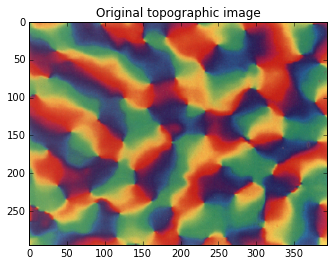

In [3]:
# Orientation preference map: for now, use k-means on Blasdel image
rgb_img = mpimg.imread('v1-topology-blasdel-figure6.png')

plt.figure()
plt.imshow(rgb_img)
plt.title('Original topographic image')

lab_img = color.rgb2lab(rgb_img) # convert to L*a*b* colourspace

ab = lab_img[:,:,1:]
n_rows = np.shape(ab)[0]
n_cols = np.shape(ab)[1]

ab = np.reshape(ab, (n_rows*n_cols, 2))
n_colours = 6

centroids, labels = kmeans2(ab, n_colours, iter=3)

labels = np.reshape(labels, (n_rows, n_cols))

rgb_labels = np.tile(labels[:,:,None], [1,1,3])

OP_range = np.linspace(0, 180, n_colours)
full_OP_map = np.copy(labels)

for i in range(n_colours):
    seg_img = np.copy(rgb_img)
    seg_img[rgb_labels != i] = 0  
    
    # assign an orientation preference (degrees) based on segmentation
    full_OP_map[full_OP_map == i] = OP_range[i]
    
    # Show the individual segmented images:
#     plt.figure()
#     plt.imshow(seg_img)


In [4]:
N_pairs = 75 # no. of E/I pairs to a side of a grid
field_size = 16. # size of field to a side (degrees)
dx = field_size / N_pairs

xy_range = np.linspace(0, field_size, N_pairs)
# xy_range = np.linspace(-field_size/2, field_size/2, N_pairs)

xv, yv = np.meshgrid(xy_range, xy_range) # x and y grid values (degrees)

# sample the OP map uniformly 
min_dim = np.min(np.shape(full_OP_map))
o_samples = np.round(np.linspace(0, min_dim-1, N_pairs))

xo, yo = np.meshgrid(o_samples, o_samples)

xo = xo.astype(int)
yo = yo.astype(int)

OP_map = full_OP_map[xo,yo]

# Rodent map
# OP_map = np.floor(np.random.rand(N_pairs, N_pairs)*180)

# Connection weight parameters (from supp. materials S1.1.2):
kappa_E = 0.1
kappa_I = 0.5
J_EE = 0.1
J_IE = 0.38
J_EI = 0.089
J_II = 0.096

sig_EE = 8*dx
sig_IE = 12*dx
sig_EI = 4*dx
sig_II = 4*dx
sig_ori = 45

# calculate probability of no connections for each neuron (sparse connectivity)

G_EE = np.zeros((N_pairs**2, N_pairs, N_pairs))
G_IE = np.copy(G_EE)

# may not need these
G_EI = np.copy(G_EE)
G_II = np.copy(G_EE)

G_ori = np.copy(G_EE)

pW_EE = np.copy(G_EE)
pW_IE = np.copy(G_EE)
pW_EI = np.copy(G_EE)
pW_II = np.copy(G_EE)

rnd_EE = np.copy(G_EE)
rnd_IE = np.copy(G_EE)
rnd_EI = np.copy(G_EE)
rnd_II = np.copy(G_EE)
np.random.seed(1)

# iterate through each E/I pair:
for i in range(N_pairs):
    for j in range(N_pairs):
        G_EE[N_pairs*i+j, :, :] = G2D( xv, yv, (xv[0,i] , yv[j,0]), sig_EE)
        G_IE[N_pairs*i+j, :, :] = G2D( xv, yv, (xv[0,i] , yv[j,0]), sig_IE)
        
        # do we need these? it doesn't appear that way in the methods...
        G_EI[N_pairs*i+j, :, :] = G2D( xv, yv, (xv[0,i] , yv[j,0]), sig_EI)
        G_II[N_pairs*i+j, :, :] = G2D( xv, yv, (xv[0,i] , yv[j,0]), sig_II)
        
#         G_ori[N_pairs*i+j, :, :] = G2DO((i,j), sig_ori, OP_map)
        G_ori[N_pairs*i+j,:,:] = G(OP_map[j,i], OP_map, sig_ori)
        rnd_EE[N_pairs*i+j, :, :] = np.random.rand(N_pairs, N_pairs)
        rnd_IE[N_pairs*i+j, :, :] = np.random.rand(N_pairs, N_pairs)
        rnd_EI[N_pairs*i+j, :, :] = np.random.rand(N_pairs, N_pairs)
        rnd_II[N_pairs*i+j, :, :] = np.random.rand(N_pairs, N_pairs)

for i in range(N_pairs**2):
    pW_EE[i,:,:] = kappa_E * np.multiply(G_EE[i,:,:], G_ori[i,:,:])
    pW_IE[i,:,:] = kappa_E * np.multiply(G_IE[i,:,:], G_ori[i,:,:])
    pW_EI[i,:,:] = kappa_I * np.multiply(G_EE[i,:,:], G_ori[i,:,:])
    pW_II[i,:,:] = kappa_I * np.multiply(G_IE[i,:,:], G_ori[i,:,:])

    pW_EI[i,:,:] = kappa_I * np.multiply(G_EI[i,:,:], G_ori[i,:,:])
    pW_II[i,:,:] = kappa_I * np.multiply(G_II[i,:,:], G_ori[i,:,:])
    
# find zero-weighted connections:
W_EE = np.ones((N_pairs**2, N_pairs, N_pairs))
W_IE = np.copy(W_EE)
W_EI = np.copy(W_EE)
W_II = np.copy(W_EE)

W_EE[pW_EE<rnd_EE] = 0
W_IE[pW_IE<rnd_IE] = 0
W_EI[pW_EI<rnd_EI] = 0
W_II[pW_II<rnd_II] = 0

u_EE = mean_connections(W_EE)
u_IE = mean_connections(W_IE)
u_EI = mean_connections(W_EI)
u_II = mean_connections(W_II)

Neuron O preference:  0


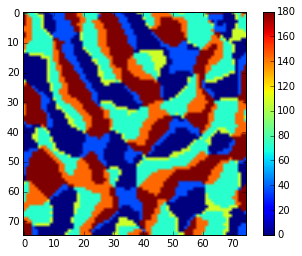

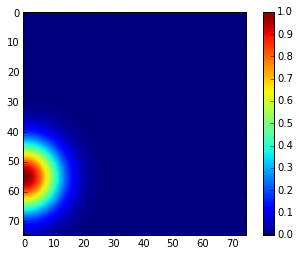

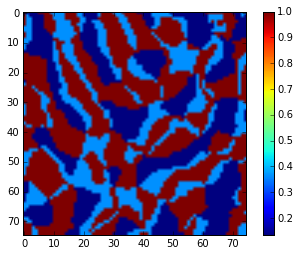

In [5]:
plt.figure()
plt.imshow(OP_map)
plt.colorbar()

plt.figure()
plt.imshow(G_EE[55,:,:])
plt.colorbar()

plt.figure()
plt.imshow(G_ori[55,:,:])
plt.colorbar()

print 'Neuron O preference: ', OP_map[55,0] 

In [6]:
# For non-zero connections, determine the weight 
W_EE[W_EE != 0] = np.random.normal(J_EE, 0.25*J_EE, W_EE[W_EE!=0].size)
W_IE[W_IE != 0] = np.random.normal(J_IE, 0.25*J_IE, W_IE[W_IE!=0].size)
W_EI[W_EI != 0] = np.random.normal(J_EI, 0.25*J_EI, W_EI[W_EI!=0].size)
W_II[W_II != 0] = np.random.normal(J_II, 0.25*J_II, W_II[W_II!=0].size)

# Set negative weights to zero:
W_EE[W_EE < 0] = 0
W_IE[W_IE < 0] = 0
W_EI[W_EI < 0] = 0
W_II[W_II < 0] = 0

# "Weights of a given type 'b' onto each unit 
# are then scaled so that all units of a given type 'a' receive the same 
# total type b synaptic weight, equal to Jab times the mean number of 
# connections received under p (Wab(x, x′) ̸= 0)"
for i in range(N_pairs**2):
    if np.all(W_EE[i,:,:] == np.zeros((N_pairs, N_pairs))) == False:
        W_EE[i,:,:] = W_EE[i,:,:]*J_EE*u_EE/np.sum(W_EE[i,:,:])
    
    if np.all(W_IE[i,:,:] == np.zeros((N_pairs, N_pairs))) == False:
        W_IE[i,:,:] = W_IE[i,:,:]*J_IE*u_IE/np.sum(W_IE[i,:,:])

    if np.all(W_EI[i,:,:] == np.zeros((N_pairs, N_pairs))) == False:
        W_EI[i,:,:] = W_EI[i,:,:]*J_EI*u_EE/np.sum(W_EI[i,:,:])

    if np.all(W_II[i,:,:] == np.zeros((N_pairs, N_pairs))) == False:
        W_II[i,:,:] = W_II[i,:,:]*J_II*u_EE/np.sum(W_II[i,:,:])

In [7]:
print 'Mean number of connections: ',u_EE, u_IE, u_EI, u_II
print 'Synaptic weight J: ', J_EE, J_IE, J_EI, J_II

print '====================='

print 'Number of elements in W_EE: ', W_EE.size
print 'number of nan elements in W_EE: ', W_EE[np.isnan(W_EE)].size

print 'indices containing nan value: ', np.where(np.isnan(W_EE))

# for i in range(10):
#     rnd = np.round(N_pairs**2*np.random.rand())
# #     plt.figure()
# #     plt.contour(W_EE[rnd,:,:])
#     print "weights for neuron %d" % rnd
#     print np.sum(W_EE[rnd,:,:])
#     print np.sum(W_IE[rnd,:,:])
#     print np.sum(W_EI[rnd,:,:])
#     print np.sum(W_II[rnd,:,:])
#     print "===================="

Mean number of connections:  16.0631111111 32.2917333333 25.2202666667 25.2216888889
Synaptic weight J:  0.1 0.38 0.089 0.096
Number of elements in W_EE:  31640625
number of nan elements in W_EE:  0
indices containing nan value:  (array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))


In [8]:
print W_EE[3296,:,:]
print 'sum: ', np.sum(W_EE[3296,:,:])

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
sum:  1.60631111111


In [9]:
# Model parameters (from supplementary methods)

k   = np.random.normal(0.012, 0.05*0.012, (N_pairs, N_pairs))
n_E = np.random.normal(2.0, 0.05*2.0, (N_pairs, N_pairs)) 
n_I = np.random.normal(2.2, 0.05*2.2, (N_pairs, N_pairs))
sig_FF = 32
sig_RF = dx

tau_E = np.random.normal(0.02, 0.05*0.02, (N_pairs, N_pairs))
tau_I = np.random.normal(0.01, 0.05*0.01, (N_pairs, N_pairs))

In [12]:
# determine external input h(x)
stim_ori = 45 # stimulus orientation (degrees)
length = 8 # stimulus size (degrees)
stim_centre = (8,8) # stimulus centred at (degrees)

x_distance = np.abs(xv - stim_centre[0])
y_distance = np.abs(yv - stim_centre[1])

dist = np.sqrt(x_distance**2 + y_distance**2)

s_l = stimulus_size(dist, length, sig_RF)
G_FF = G(stim_ori, OP_map, sig_FF)
h = np.multiply( s_l, G_FF )
# h = G_FF # Full frame stimulus

<matplotlib.colorbar.Colorbar instance at 0x158896ef0>

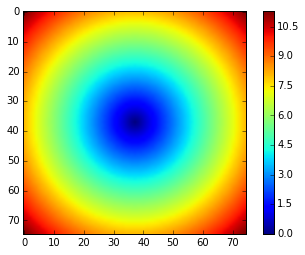

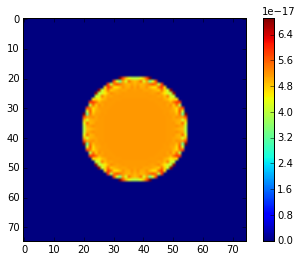

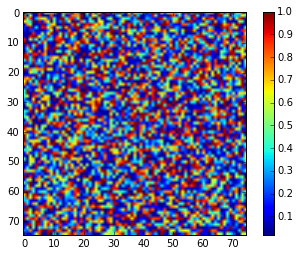

In [120]:
plt.figure()
plt.imshow(dist)
plt.colorbar()

plt.figure()
plt.imshow(s_l)
plt.colorbar()

plt.figure()
plt.imshow(G_FF)
plt.colorbar()

In [10]:
def generate_ext_stimulus(ori, stim_size, centre, full_frame=False):
    G_FF = G(ori, OP_map, sig_FF)
    
    if full_frame==True:
        h = G_FF
    else:
        x_distance = np.abs(xv - centre[0])
        y_distance = np.abs(yv - centre[1])
        dist = np.sqrt(x_distance**2 + y_distance**2)
        s_l = stimulus_size(dist, stim_size, sig_RF)
#         h = np.multiply( s_l, G_FF )
        h = s_l * G_FF
        
    return h

In [11]:
s = stimulus_size(dist, 16, sig_RF)
plt.figure()
plt.imshow(s)
plt.colorbar()



NameError: name 'dist' is not defined

In [15]:
# Run the simulation over time using Euler's method
dt = 0.001 # milliseconds
timesteps = 100

r_E = np.zeros((timesteps, N_pairs, N_pairs))
r_I = np.copy(r_E)

# Initial conditions:
# r_E[0,:,:] = 100*np.random.rand(N_pairs, N_pairs)
# r_I[0,:,:] = 100*np.random.rand(N_pairs, N_pairs)

I_E = np.zeros((timesteps, N_pairs, N_pairs))
I_I = np.copy(I_E)
# rSS_E = np.copy(I_E)
# rSS_I = np.copy(I_I)

for t in range(1,timesteps):
    # Input drive from external input and network
    
#     print W_EE.shape
#     print r_E[:,:,t-1].shape
#     print np.multiply(W_EE, r_E[t-1,:,:]).shape
    
    I_E[t,:,:] = c*h + np.sum( np.reshape(np.multiply(W_EE, r_E[t-1,:,:]), (N_pairs, N_pairs, N_pairs**2)), 2).T + np.sum( np.reshape(np.multiply(W_EI, r_I[t-1,:,:]), (N_pairs, N_pairs, N_pairs**2)), 2).T
    I_I[t,:,:] = c*h + np.sum( np.reshape(np.multiply(W_IE, r_E[t-1,:,:]), (N_pairs, N_pairs, N_pairs**2)), 2).T + np.sum( np.reshape(np.multiply(W_II, r_I[t-1,:,:]), (N_pairs, N_pairs, N_pairs**2)), 2).T
    
    # steady state firing rates - power law I/O
    rSS_E = np.multiply(k, np.power(np.maximum(0,I_E[t,:,:]), n_E))
    rSS_I = np.multiply(k, np.power(np.maximum(0,I_I[t,:,:]), n_I))
    
    # set negative steady state rates to zero
#     rSS_E[t,:,:][rSS_E[t,:,:] < 0] = 0
#     rSS_I[t,:,:][rSS_I[t,:,:] < 0] = 0
    
    # instantaneous firing rates approaching steady state
    r_E[t,:,:] = r_E[t-1,:,:] + dt*(np.divide(-r_E[t-1,:,:]+rSS_E, tau_E))
    r_I[t,:,:] = r_I[t-1,:,:] + dt*(np.divide(-r_I[t-1,:,:]+rSS_I, tau_I))

In [12]:
def run_simulation( dt, timesteps, c, h, init_cond=[np.zeros((N_pairs, N_pairs)),np.zeros((N_pairs, N_pairs))]):

    r_E = np.zeros((timesteps, N_pairs, N_pairs))
    r_I = np.copy(r_E)

    # add initial conditions:
    r_E[0,:,:] = init_cond[0]
    r_I[0,:,:] = init_cond[1]

    I_E = np.zeros((timesteps, N_pairs, N_pairs))
    I_I = np.copy(I_E)
    # rSS_E = np.copy(I_E)
    # rSS_I = np.copy(I_I)

    for t in range(1,timesteps):
        # Input drive from external input and network

    #     print W_EE.shape
    #     print r_E[:,:,t-1].shape
    #     print np.multiply(W_EE, r_E[t-1,:,:]).shape
        
        for i in range(N_pairs):
            for j in range(N_pairs):
                I_E[t,j,i] = c*h[j,i] + np.sum( np.multiply( W_EE[i*N_pairs+j,:,:], r_E[t-1,:,:]) ) + np.sum( np.multiply( W_EI[i*N_pairs+j,:,:], r_I[t-1,:,:]) )
                I_I[t,j,i] = c*h[j,i] + np.sum( np.multiply( W_IE[i*N_pairs+j,:,:], r_E[t-1,:,:]) ) + np.sum( np.multiply( W_II[i*N_pairs+j,:,:], r_I[t-1,:,:]) )
#         I_E[t,:,:] = c*h + np.sum( np.reshape(np.multiply(W_EE, r_E[t-1,:,:]), (N_pairs, N_pairs, N_pairs**2)), 2).T + np.sum( np.reshape(np.multiply(W_EI, r_I[t-1,:,:]), (N_pairs, N_pairs, N_pairs**2)), 2).T
#         I_I[t,:,:] = c*h + np.sum( np.reshape(np.multiply(W_IE, r_E[t-1,:,:]), (N_pairs, N_pairs, N_pairs**2)), 2).T + np.sum( np.reshape(np.multiply(W_II, r_I[t-1,:,:]), (N_pairs, N_pairs, N_pairs**2)), 2).T

        # steady state firing rates - power law I/O
        rSS_E = np.multiply(k, np.power(I_E[t,:,:], n_E))
        rSS_I = np.multiply(k, np.power(I_I[t,:,:], n_I))

        # set negative steady state rates to zero
        rSS_E[rSS_E < 0] = 0
        rSS_I[rSS_I < 0] = 0

        # instantaneous firing rates approaching steady state
        r_E[t,:,:] = r_E[t-1,:,:] + dt*(np.divide(-r_E[t-1,:,:]+rSS_E, tau_E))
        r_I[t,:,:] = r_I[t-1,:,:] + dt*(np.divide(-r_I[t-1,:,:]+rSS_I, tau_I))

    return [r_E, r_I, I_E, I_I]

/Users/mollybeckel/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:31: RuntimeWarning: overflow encountered in power
/Users/mollybeckel/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:24: RuntimeWarning: invalid value encountered in multiply
/Users/mollybeckel/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:25: RuntimeWarning: invalid value encountered in multiply
/Users/mollybeckel/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:34: RuntimeWarning: invalid value encountered in less
/Users/mollybeckel/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:35: RuntimeWarning: invalid value encountered in less


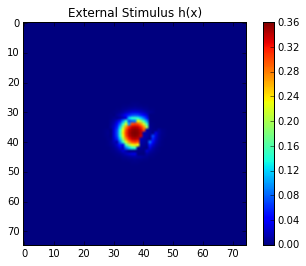

In [13]:
h = generate_ext_stimulus(45, 2, (8,8))

plt.figure()
plt.imshow(h)
plt.title('External Stimulus h(x)')
plt.colorbar()

[r_E, r_I, I_E, I_I] = run_simulation(0.001, 100, 40, h)


r_E:  [  0.00000000e+000   3.74294037e-014   7.28435272e-014   1.76575149e-013
   1.10354708e-012   7.74395962e-012   4.02410820e-011   1.59376104e-010
   5.14411050e-010   1.42353129e-009   3.49983248e-009   7.84003318e-009
   1.62995642e-008   3.18875815e-008   5.93306280e-008   1.05877126e-007
   1.82451521e-007   3.05325007e-007   4.98563602e-007   7.97669018e-007
   1.25508896e-006   1.94872635e-006   2.99538648e-006   4.57259770e-006
   6.95511924e-006   1.05782345e-005   1.61521776e-005   2.48796002e-005
   3.88946608e-005   6.22184229e-005   1.03043879e-004   1.79918335e-004
   3.41518724e-004   7.47082104e-004   2.14195671e-003   1.13180827e-002
   3.11759077e-001   8.38011602e+002   2.09695715e+011   8.81493204e+031
   6.69746713e+085   1.57603229e+223               nan               nan
               nan               nan               nan               nan
               nan               nan               nan               nan
               nan               nan         

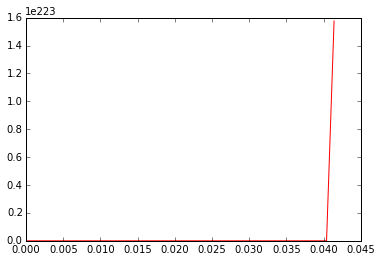

In [14]:
plt.figure()
plt.plot(np.linspace(0,0.1,100), r_E[:,50,50],'r')
print 'r_E: ', r_E[:,50,50]

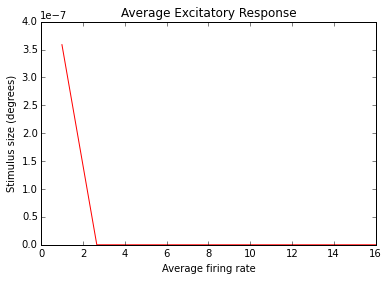

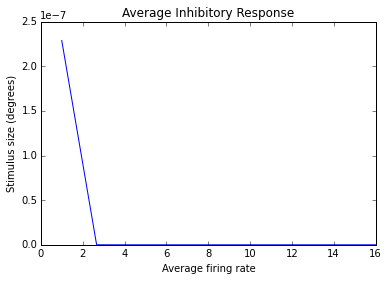

In [85]:
# run simulations to reproduce mean length tuning curves, figure 6E
size_range = np.linspace(1,16,10) # size
c = 40
stim_ori = 45 # degrees
centre = (8,8)
h_range = np.zeros((len(size_range), N_pairs, N_pairs))

for i in range(len(size_range)):
    h_range[i,:,:] = generate_ext_stimulus(stim_ori, size_range[i], centre)

dt = 0.001
timesteps = 100

avg_r_E = np.zeros(len(size_range))
avg_r_I = np.copy(avg_r_E)

for i in range(len(size_range)):
    [r_E, r_I] = run_simulation(dt, timesteps, c, h_range[i])
    avg_r_E[i] = np.mean(r_E)
    avg_r_I[i] = np.mean(r_I)
    
plt.figure()
plt.plot(size_range, avg_r_E, 'r')
plt.title('Average Excitatory Response')
plt.xlabel('Average firing rate')
plt.ylabel('Stimulus size (degrees)')

plt.figure()
plt.plot(size_range, avg_r_I, 'b')
plt.title('Average Inhibitory Response')
plt.xlabel('Average firing rate')
plt.ylabel('Stimulus size (degrees)')

In [86]:
print avg_r_E, '\n\n', avg_r_I

[  3.58673201e-07   7.46532749e-13   9.06952066e-19   1.27082017e-24
   2.27046880e-30   2.26940248e-36   3.10453883e-42   1.82709553e-48
   7.98128651e-57   0.00000000e+00] 

[  2.28806503e-07   9.80173496e-14   3.01025953e-20   1.26517509e-26
   4.81052653e-33   1.62165545e-39   6.99797182e-46   3.57705747e-54
   2.55116273e-64   0.00000000e+00]


[[ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 ..., 
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]]
[  1.           2.66666667   4.33333333   6.           7.66666667
   9.33333333  11.          12.66666667  14.33333333  16.        ]


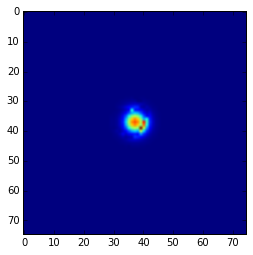

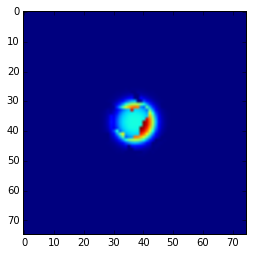

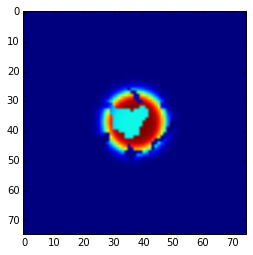

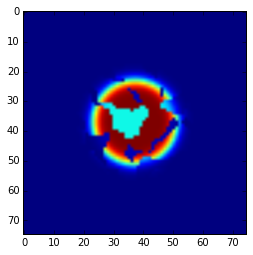

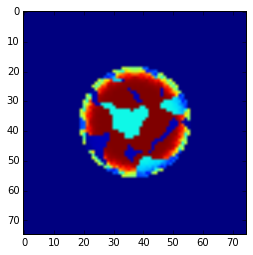

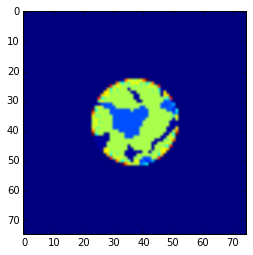

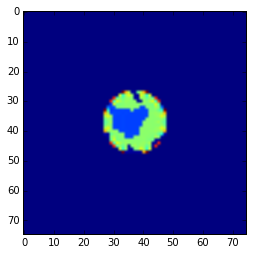

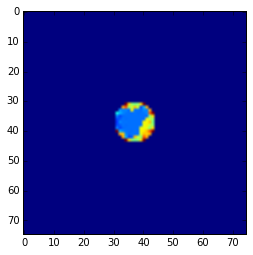

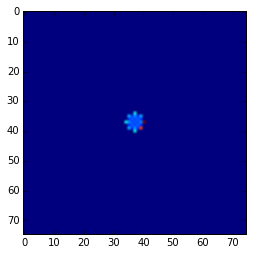

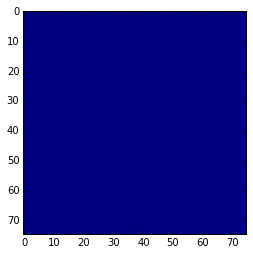

In [39]:
size_range = np.linspace(1,16,10) # size
c = 40
stim_ori = 45 # degrees
centre = (8,8)
h_range = np.zeros((len(size_range), N_pairs, N_pairs))

for i in range(len(size_range)):
    h_range[i,:,:] = generate_ext_stimulus(stim_ori, size_range[i], centre)

for i in range(len(h_range)):
    plt.figure()
    plt.imshow(h_range[i])
    
print h_range[1] == h_range[9]

print size_range

[ 56.  28.  19.  56.  55.  25.  31.  70.  18.  52.] [ 56.   6.  59.   7.  53.  14.   3.  27.  53.  19.]


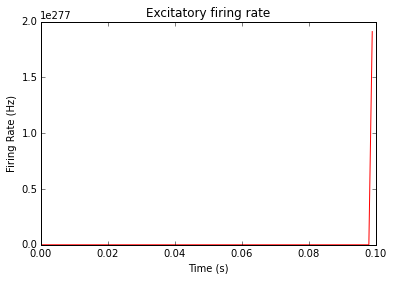

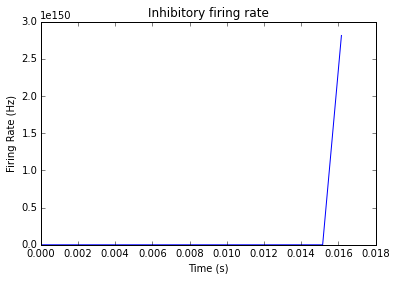

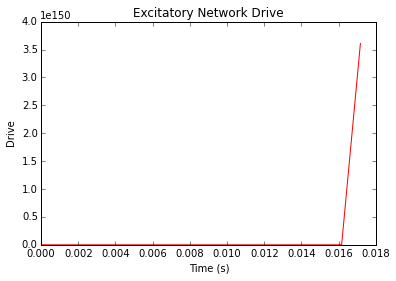

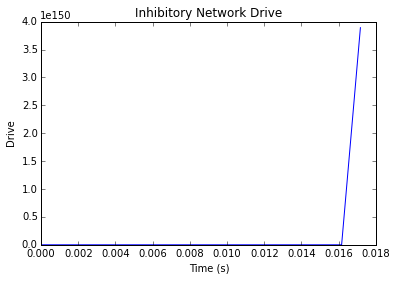

In [105]:
# Plotting results
n_plots = 10
x = np.floor(N_pairs*np.random.rand(n_plots))
y = np.floor(N_pairs*np.random.rand(n_plots))

print x,y

plt.figure()
plt.hold(True)
t_range = np.linspace(0,timesteps*dt, timesteps)

for i in range(n_plots):
    plt.plot( t_range, r_E[:,x[i],y[i]], 'r' )
plt.xlabel('Time (s)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Excitatory firing rate')
plt.show()

plt.figure()
plt.plot(t_range, r_I[:,x[0],y[0]] )
plt.xlabel('Time (s)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Inhibitory firing rate')

plt.figure()
plt.plot(t_range, I_E[:,x[0],y[0]], 'r')
plt.xlabel('Time (s)')
plt.ylabel('Drive')
plt.title('Excitatory Network Drive')

plt.figure()
plt.plot(t_range, I_I[:,x[0],y[0]])
plt.xlabel('Time (s)')
plt.ylabel('Drive')
plt.title('Inhibitory Network Drive')